# Model Selecton and Experimentation

In this notebook, I try different models to predict the property prices based on my curated dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
final_features = pd.read_pickle(r"Data\final_features.pkl")
final_features

,num_area,lease_left,float_x,float_y,floor_range,property_type,num_price
0,2.105138,-0.679003,-0.239045,-2.341849,-0.904656,0.924381,2741000
1,2.744592,-0.791506,-0.239045,-2.341849,-0.904656,0.924381,3254850
2,2.744592,-0.791506,-0.239045,-2.341849,-0.904656,0.924381,4068160
3,2.105138,-0.679003,-0.239045,-2.341849,-0.904656,0.924381,2793790
4,2.211713,-0.791506,-0.239045,-2.341849,-0.904656,0.924381,3071880
...,...,...,...,...,...,...,...
84076,-0.580569,0.671041,-0.237942,1.884183,-0.328245,-0.430927,1029480
84077,-0.495308,0.671041,-0.237942,1.884183,-0.904656,-0.430927,1121420
84078,0.250721,0.671041,-0.237942,1.884183,-0.904656,-0.430927,1417780
84079,-0.793720,0.671041,-0.237942,1.884183,-0.328245,-0.430927,880200


In [3]:
from sklearn.model_selection import train_test_split

# Split data into training and validation data, for both features and target
y = final_features["num_price"]
X = final_features[["num_area", "floor_range", "property_type", "lease_left", "float_x", "float_y"]]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

### Random Forest Regressor Implementation (Vs dummy)

Here I implement a dummy regressor that outputs the mean for all predictions, as a benchmark model to compare my subsequent models with. I will compare the Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RMSE). First, I compare it with Random Forest Regressor.

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Dummy Model (mean)
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(train_X, train_y)
data_pred = dummy_regr.predict(val_X)

print("Mean Absolute Error (Dummy): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Dummy): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Dummy): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Random Forest Regressor
rand_forest = RandomForestRegressor(random_state=1)
rand_forest.fit(train_X, train_y)
data_pred = rand_forest.predict(val_X)

# Printing Accuracy of Model
print("Mean Absolute Error (Rand_forest): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Rand_forest): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Rand_forest): {}".format((mean_squared_error(val_y, data_pred)**0.5)))

Mean Absolute Error (Dummy): 458614.5654738787
Mean Squared Error (Dummy): 540363704185.5847
Root Mean Squared Error (Dummy): 735094.3505330351


Mean Absolute Error (Rand_forest): 49900.75039088787
Mean Squared Error (Rand_forest): 16861483514.243322
Root Mean Squared Error (Rand_forest): 129851.77516785561


The random forest regressor performed significantly better than the dummy.

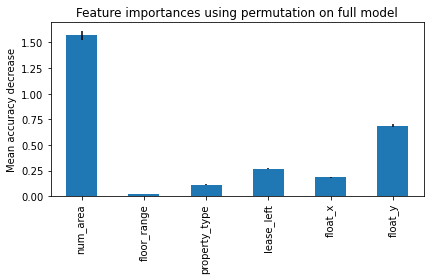

In [5]:
from sklearn.inspection import permutation_importance

# Calculating Feature Importance
result = permutation_importance(rand_forest, val_X, val_y)
feature_names = ["num_area", "floor_range", "property_type", "lease_left", "float_x", "float_y"]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

# Plotting Graph
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Model Selection (Performance of other types of regressor models)

In the final cell below, I tested a few other types of models to compare against the tree based model, Random Forest. 
- Ridge Regression
- Multi-layer Perceptron Regressor (Tweaked the learning rate and max-iteration for this, since default learning rate could not converge with the default number of iterations)

In [7]:
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor

# Multi-variable Linear Regression
linear_reg = linear_model.Ridge(alpha=.5)
linear_reg.fit(train_X, train_y)
data_pred = linear_reg.predict(val_X)

print("Mean Absolute Error (Ridge_reg): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Ridge_reg): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Ridge_reg): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Neural Network (Multi-layer Perceptron Regressor) (1 layer, 10 nodes)
neural_network_reg = MLPRegressor(hidden_layer_sizes=(10,), random_state=1, solver='adam', max_iter=1000, learning_rate_init= 0.01)
neural_network_reg.fit(train_X, train_y)
data_pred = neural_network_reg.predict(val_X)

print("Mean Absolute Error (Neural_network_reg_1): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Neural_network_reg_1): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Neural_network_reg_1): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Neural Network (Multi-layer Perceptron Regressor) (2 layer, 10 nodes each)
neural_network_reg = MLPRegressor(hidden_layer_sizes=(10, 10), random_state=1, solver='adam', max_iter=1000, learning_rate_init= 0.01)
neural_network_reg.fit(train_X, train_y)
data_pred = neural_network_reg.predict(val_X)

print("Mean Absolute Error (Neural_network_reg_3): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Neural_network_reg_3): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Neural_network_reg_3): {}".format((mean_squared_error(val_y, data_pred)**0.5)))

Mean Absolute Error (Ridge_reg): 258861.93988274503
Mean Squared Error (Ridge_reg): 193631969369.09183
Root Mean Squared Error (Ridge_reg): 440036.32732888294




c:\Users\Roydon\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Absolute Error (Neural_network_reg_1): 241262.1168715904
Mean Squared Error (Neural_network_reg_1): 167161466742.7981
Root Mean Squared Error (Neural_network_reg_1): 408853.8452097499




c:\Users\Roydon\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Absolute Error (Neural_network_reg_2): 233989.6027983035
Mean Squared Error (Neural_network_reg_2): 155954814100.0844
Root Mean Squared Error (Neural_network_reg_2): 394911.14709524775


Mean Absolute Error (Neural_network_reg_3): 169305.76399750865
Mean Squared Error (Neural_network_reg_3): 74256022975.99408
Root Mean Squared Error (Neural_network_reg_3): 272499.58344187256


c:\Users\Roydon\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Compared to random forest regressor:

- Mean Absolute Error (Rand_forest): 49900.75039088787
- Mean Squared Error (Rand_forest): 16861483514.243322
- Root Mean Squared Error (Rand_forest): 129851.77516785561

Without any hyperparameter tuning, tree based model seem to outperformed other types of models significantly. Adding more nodes of the Neural Network model appears to reduce model accuracy, while increasing the number of layers improved accuracy slightly, but its performance it is still far from the accuracy of the Random Forest model.

With this in consideration, I decided to compare Random Forest to another tree-based model, XGBoost, to see which performs better.

## Comparing Tree Based Models (XGBoost Vs Random Forest)

In [8]:
import xgboost as xg

xgb_reg = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
xgb_reg.fit(train_X, train_y)
data_pred = xgb_reg.predict(val_X)

print("Mean Absolute Error (XGBoost_Reg): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (XGBoost_Reg): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (XGBoost_Reg): {}".format((mean_squared_error(val_y, data_pred)**0.5)))

Mean Absolute Error (XGBoost_Reg): 138099.23572558395
Mean Squared Error (XGBoost_Reg): 53482020168.27897
Root Mean Squared Error (XGBoost_Reg): 231261.80006278376


XGBoost perfromed better than Linear and Neural Network methods as well, but still did not beat Random Forest Model. Hence, I decided to go with the Random Forest model.

In [10]:
import pickle

# Saving best model to pickle
pickle.dump(rand_forest, open('best_model.pkl', 'wb'))